In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-marketing-dataset/bank.csv


Firstly, lets start from reading the dataset and looking it's info and numerical feature statistics

In [2]:
data = pd.read_csv("/kaggle/input/bank-marketing-dataset/bank.csv")
print(data.info())
print(data.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB
None
            count         mean          std     min    25%    50%      75%  \
age       11162.

So, in this dataset, we are provided with client data. Our target variable is deposit, and the task is to predict, whether some specific client will get a long term deposit or not. As it is a binary variable, it means that we are dealing with classification problem

We see that there are no missing data in our dataset, this is very good for us because linear models tend to work worse with it

Now, lets look at the distribution of this target variable, to see if it is balanced, or not.

<Axes: xlabel='deposit'>

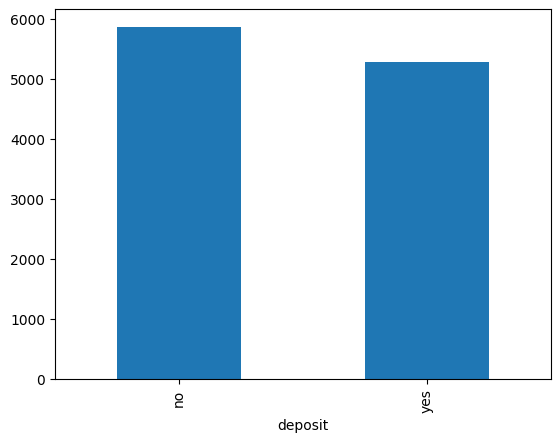

In [3]:
data.deposit.value_counts().plot(kind='bar')

We see that our target's distribution is balanced, it's good news for us, because it means that our model won't result in high bias

Now, lets start preprocessing our data by first looking at our object variables and determining whether they are ordinal or categorical

In [4]:
object_cols = ["job", "marital", "education", "default", 
               "housing", "loan", "contact", "month", "deposit", "poutcome"]
for col in object_cols:
    print(data[col].value_counts())
    print("\n\n")

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64



marital
married     6351
single      3518
divorced    1293
Name: count, dtype: int64



education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64



default
no     10994
yes      168
Name: count, dtype: int64



housing
no     5881
yes    5281
Name: count, dtype: int64



loan
no     9702
yes    1460
Name: count, dtype: int64



contact
cellular     8042
unknown      2346
telephone     774
Name: count, dtype: int64



month
may    2824
aug    1519
jul    1514
jun    1222
nov     943
apr     923
feb     776
oct     392
jan     344
sep     319
mar     276
dec     110
Name: count, dtype: int64



deposit
no     5873
yes    5289
Name: count, dtype: 

So, the binary variables for us are deposit, loan, housing and default, we will replace them with ones and zeroes



In [5]:
binary_variables = ["deposit", "loan", "housing","default"]
for var in binary_variables:
    data[var] = data[var].map({"yes" : 1, "no" : 0})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  int64 
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  int64 
 7   loan       11162 non-null  int64 
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  int64 
dtypes: int64(11), object(6)
memory usage: 1.4+ MB


Now, lets look at ordinal variables, in our example, they are education and poutcome, we can't just one-hot encode them, because order matters, so we will preprocess them like this

In [6]:
education_dict = {
    "unknown" : 0, 
    "primary" : 1, 
    "secondary" : 2, 
    "tertiary" : 3
}
data["education"] = data["education"].map(education_dict)
data["education"].value_counts()

education
2    5476
3    3689
1    1500
0     497
Name: count, dtype: int64

In [7]:
poutcome_dict = {
    "unknown" : 0, 
    "failure" : 1, 
    "other" : 2, 
    "success" : 3
}
data["poutcome"] = data["poutcome"].map(poutcome_dict)
data["poutcome"].value_counts()

poutcome
0    8326
1    1228
3    1071
2     537
Name: count, dtype: int64

Now, lets one-hot encode the categorical variables

In [8]:
data = pd.get_dummies(data, columns=["job", "marital", "contact", "month"])


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                11162 non-null  int64
 1   education          11162 non-null  int64
 2   default            11162 non-null  int64
 3   balance            11162 non-null  int64
 4   housing            11162 non-null  int64
 5   loan               11162 non-null  int64
 6   day                11162 non-null  int64
 7   duration           11162 non-null  int64
 8   campaign           11162 non-null  int64
 9   pdays              11162 non-null  int64
 10  previous           11162 non-null  int64
 11  poutcome           11162 non-null  int64
 12  deposit            11162 non-null  int64
 13  job_admin.         11162 non-null  bool 
 14  job_blue-collar    11162 non-null  bool 
 15  job_entrepreneur   11162 non-null  bool 
 16  job_housemaid      11162 non-null  bool 
 17  job_manageme

Now, lets scale our numerical features

In [10]:
num_features = ["age", "balance", "day", "duration",
                "campaign", "pdays", "previous", 
                "poutcome", "education"]

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[num_features] = scaler.fit_transform(data[num_features])
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,2.749995e-16,1.000045,-1.950161,-0.774958,-0.187357,0.652074,4.513455
education,11162.0,-1.807867e-16,1.000045,-2.651442,-0.134720,-0.134720,1.123641,1.123641
default,11162.0,1.505107e-02,0.121761,0.000000,0.000000,0.000000,0.000000,1.000000
balance,11162.0,1.018517e-17,1.000045,-2.596850,-0.436100,-0.303398,0.055642,24.703510
housing,11162.0,4.731231e-01,0.499299,0.000000,0.000000,0.000000,1.000000,1.000000
loan,11162.0,1.308009e-01,0.337198,0.000000,0.000000,0.000000,0.000000,1.000000
day,11162.0,-2.037033e-17,1.000045,-1.740784,-0.909466,-0.078148,0.753170,1.822008
duration,11162.0,8.148134e-17,1.000045,-1.065918,-0.674115,-0.337048,0.357250,10.109123
campaign,11162.0,3.055550e-17,1.000045,-0.554168,-0.554168,-0.186785,0.180598,22.223576
pdays,11162.0,5.092584e-18,1.000045,-0.481184,-0.481184,-0.481184,-0.281190,7.380638


Great, now, lets split our data in training and test datasets

In [12]:
X, y = data.drop("deposit", axis=1), data.deposit

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=54)

And now, it's finally time to build and train our model. The first one is mlp, which stands for multi-layer Perceptron, we will use it's classifier version. This model is basic neural network representation in sklearn library, and it's pretty limited, but it will do for now

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix

mlp = MLPClassifier(solver='adam', random_state=54)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1-score:', f1_score(y_valid, y_pred))

[[1006  209]
 [ 169  849]]
F1-score: 0.8179190751445087


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Now, this is the highest F1-score we had so far in all of our models, let's see if we can improve it by tuning the hyperparameters

For this, I will consider using RandomizedSearchCV, so it will take an adequate amount of time

In [15]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "hidden_layer_sizes" : [(20,),(50,),(70,),(100,),(150,), (50,50),(100,50),(100,100),(100, 50, 25), (75, 50, 25)],
    "activation" : ["relu", "logistic", "tanh"],
    "learning_rate_init": [0.001, 0.01, 0.1],
}
model_grid = RandomizedSearchCV(mlp, param_grid, cv=5, scoring="f1", n_jobs=-1, random_state=54, n_iter=40) 
model_grid.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

RandomizedSearchCV(cv=5, estimator=MLPClassifier(random_state=54), n_iter=40,
                   n_jobs=-1,
                   param_distributions={'activation': ['relu', 'logistic',
                                                       'tanh'],
                                        'hidden_layer_sizes': [(20,), (50,),
                                                               (70,), (100,),
                                                               (150,), (50, 50),
                                                               (100, 50),
                                                               (100, 100),
                                                               (100, 50, 25),
                                                               (75, 50, 25)],
                                        'learning_rate_init': [0.001, 0.01,
                                                               0.1]},
                   random_state=54, scoring='f1')

In [16]:
print(model_grid.best_params_)
print(model_grid.best_score_)

{'learning_rate_init': 0.001, 'hidden_layer_sizes': (20,), 'activation': 'relu'}
0.8475690355983518


We managed to drastically improve our test score, now, let's plot our validation curves

In [17]:
import matplotlib.pyplot as plt
results_df = pd.DataFrame(model_grid.cv_results_)
print(results_df)

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        2.373591      0.409357         0.008855        0.000219   
1        4.799551      0.704204         0.009490        0.000519   
2       18.885416      0.247876         0.018041        0.001130   
3       14.362163      0.170918         0.015080        0.001003   
4        5.087478      0.563811         0.007339        0.000332   
5        6.477542      0.412635         0.017699        0.000507   
6        5.001480      0.359179         0.014571        0.000590   
7       11.850321      0.870247         0.011834        0.000535   
8        4.286621      0.106871         0.007660        0.002535   
9        6.258413      0.958056         0.014043        0.000417   
10       2.107575      0.296729         0.007125        0.000213   
11       4.553483      0.591563         0.012367        0.000806   
12       5.590997      0.059499         0.008098        0.000212   
13       2.441922      0.623942         0.016573

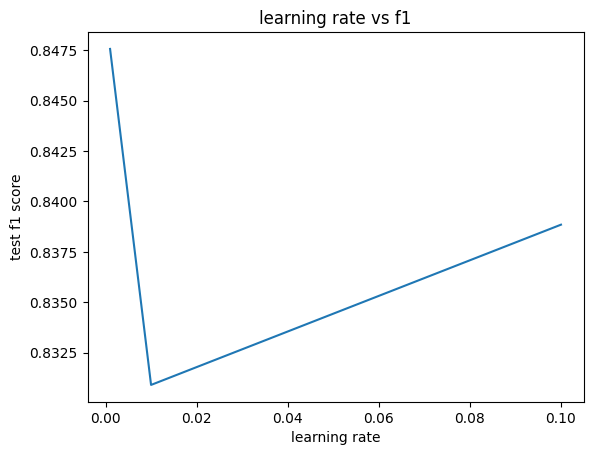

In [18]:
results_df = pd.DataFrame(model_grid.cv_results_)
plt.plot(results_df[["param_learning_rate_init", "mean_test_score"]].groupby("param_learning_rate_init").max())

plt.xlabel('learning rate')
plt.ylabel('test f1 score')
plt.title('learning rate vs f1')
plt.show()

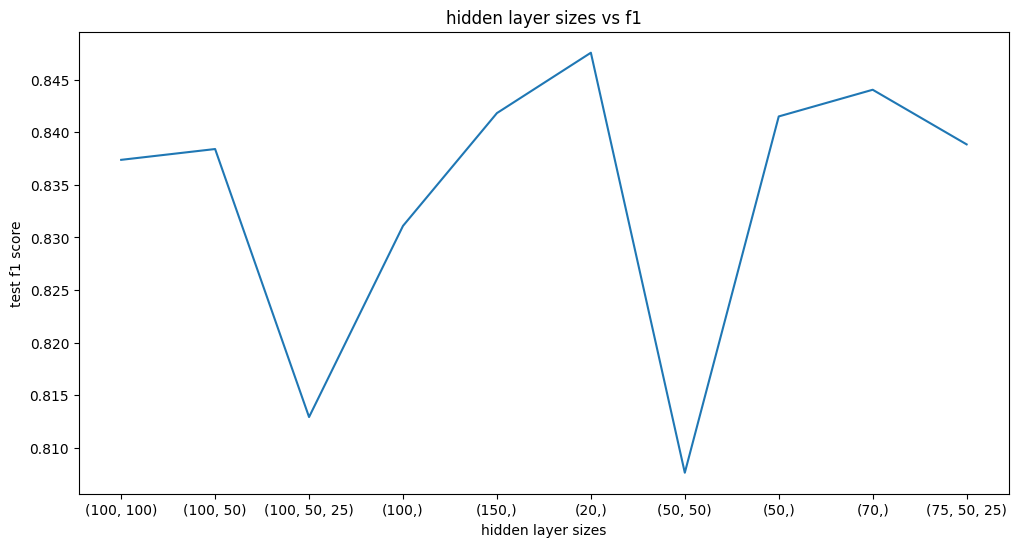

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

results_df["param_hidden_layer_sizes_str"] = results_df["param_hidden_layer_sizes"].astype(str)

plt.figure(figsize=(12, 6))  


plt.plot(results_df[["param_hidden_layer_sizes_str", "mean_test_score"]].groupby("param_hidden_layer_sizes_str").max())

plt.xlabel('hidden layer sizes')
plt.ylabel('test f1 score')
plt.title('hidden layer sizes vs f1')
plt.show()


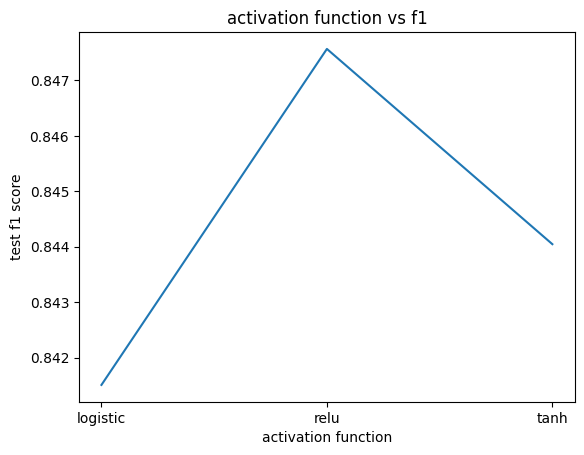

In [20]:
results_df = pd.DataFrame(model_grid.cv_results_)
plt.plot(results_df[["param_activation", "mean_test_score"]].groupby("param_activation").max())

plt.xlabel('activation function')
plt.ylabel('test f1 score')
plt.title('activation function vs f1')
plt.show()

Alright, to sum up, we see that our best performing model contains the relu activation function, one hidden layer with 20 neurons(we can see that other combinations provided us with less accurate answers, this might be due to the model overfitting) and with 0.001 learning rate.


Now, let's try using ensemles for this problem. Firstly, we will try bagging with logistic regression

In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
bagging_linear = BaggingClassifier(LogisticRegression(),
                            max_samples=0.5, max_features=1.0, n_estimators=10)

bagging_linear.fit(X_train, y_train)

BaggingClassifier(estimator=LogisticRegression(), max_samples=0.5)

In [22]:
y_pred = bagging_linear.predict(X_valid)
print('F1-score:', f1_score(y_valid, y_pred))

F1-score: 0.8059553349875932


Let's also try building the KNN bagging

In [23]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging_knn = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=1.0, n_estimators=10)

bagging_knn.fit(X_train, y_train)

BaggingClassifier(estimator=KNeighborsClassifier(), max_samples=0.5)

In [24]:
y_pred = bagging_knn.predict(X_valid)
print('F1-score:', f1_score(y_valid, y_pred))

F1-score: 0.7844129554655871


Now, let's try to tune the n_estimators parameter for both of this models

# Logistic Regression

In [25]:
from sklearn.model_selection import GridSearchCV

params={"n_estimators": np.arange(10, 121, 10)} 

grid = GridSearchCV(bagging_linear, params, cv=5, scoring="f1", n_jobs=-1) 
grid.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5,
             estimator=BaggingClassifier(estimator=LogisticRegression(),
                                         max_samples=0.5),
             n_jobs=-1,
             param_grid={'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120])},
             scoring='f1')

In [26]:
print(grid.best_params_)
print(grid.best_score_)

{'n_estimators': 100}
0.8120827093089226


Alright, so by using logistic regression bagging we got a decent result, which is almost as good as our MLP one, now, let's plot the validation curve, and then check the knn bagging

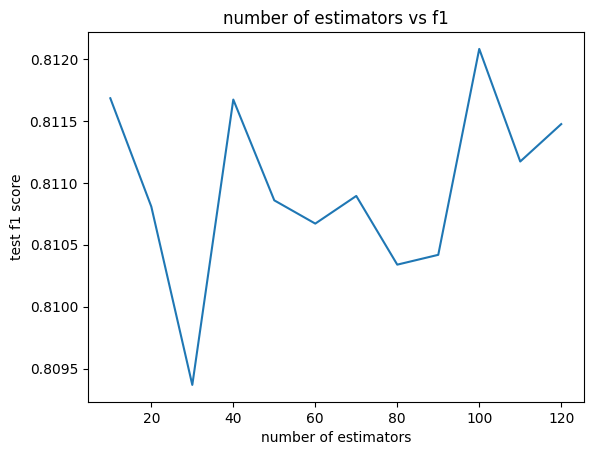

In [27]:
results_df = pd.DataFrame(grid.cv_results_)
plt.plot(results_df[["param_n_estimators", "mean_test_score"]].groupby("param_n_estimators").max())

plt.xlabel('number of estimators')
plt.ylabel('test f1 score')
plt.title('number of estimators vs f1')
plt.show()

# KNN

In [28]:
from sklearn.model_selection import GridSearchCV

params={"n_estimators": np.arange(10, 121, 10)} 

grid = GridSearchCV(bagging_knn, params, cv=5, scoring="f1", n_jobs=-1) 
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=BaggingClassifier(estimator=KNeighborsClassifier(),
                                         max_samples=0.5),
             n_jobs=-1,
             param_grid={'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120])},
             scoring='f1')

In [29]:
print(grid.best_params_)
print(grid.best_score_)

{'n_estimators': 100}
0.8003615737920912


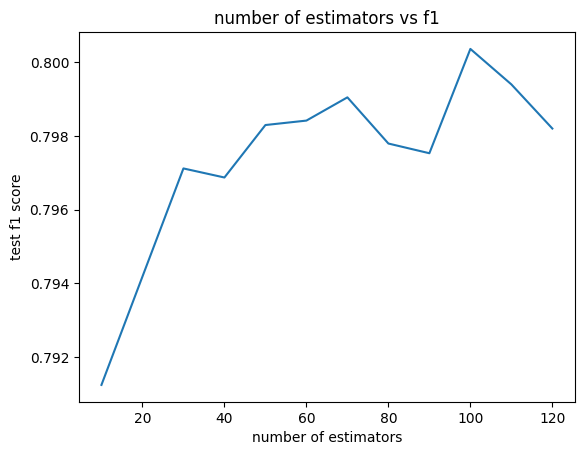

In [30]:
results_df = pd.DataFrame(grid.cv_results_)
plt.plot(results_df[["param_n_estimators", "mean_test_score"]].groupby("param_n_estimators").max())

plt.xlabel('number of estimators')
plt.ylabel('test f1 score')
plt.title('number of estimators vs f1')
plt.show()

To sum up, we see that bagging models give us pretty decent score, but they can't surpass the MLP models, let's now see how will boosting work in our example


In [31]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=54)
gb.fit(X_train, y_train)


GradientBoostingClassifier(random_state=54)

In [32]:
y_pred = gb.predict(X_valid)
print('F1-score:', f1_score(y_valid, y_pred))

F1-score: 0.8313425704730053


This is our best result yet, even surpassing the mlp model, let's now tune the n_estimators to see if we can improve this result

In [33]:
from sklearn.model_selection import GridSearchCV

params={"n_estimators": np.arange(10, 301, 10)} 

grid = GridSearchCV(gb, params, cv=5, scoring="f1", n_jobs=-1) 
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=54),
             n_jobs=-1,
             param_grid={'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300])},
             scoring='f1')

In [34]:
print(grid.best_params_)
print(grid.best_score_)

{'n_estimators': 240}
0.8526829836561284


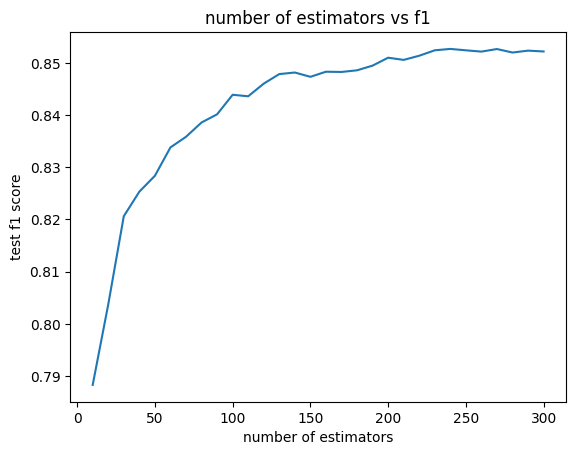

In [35]:
results_df = pd.DataFrame(grid.cv_results_)
plt.plot(results_df[["param_n_estimators", "mean_test_score"]].groupby("param_n_estimators").max())

plt.xlabel('number of estimators')
plt.ylabel('test f1 score')
plt.title('number of estimators vs f1')
plt.show()

This is the best performing model yet, giving us 0.852 f1 score, we can also see than increasing the number of estimators really helped us until one moment at about 240, when it became pretty much constant

Alright, to sum up all of our labs, the most performing model is gradient boosting, then it's MLP classifier(neural network basically),this might be connected to various factors, firstly, the MLP model presented in sklearn is not very convenient, we can't customize different layers, change the activation functions, ect. Secondly, our dataset is considered to be pretty small for training the neural network. Thirdly, neural network overall might be kind of an overkill for our task, because it's not so complex.